***
# <center>***Dropout***
***

Another option for neural network **regularization** is adding a **dropout layer** disables some neurons, while the others pass through unchanged. The idea here, similarly to regularization, is to prevent a neural network from becoming too dependent on any neuron or for any neuron to be relied upon entirely in a specific instance (which can be common if a model overfits the training data). Another problem dropout can help with is **co-adoption** happens when neurons depend on the output values of other neurons and do not learn the underlying function on their own. Dropout can also help with **noise**, which and other perturbations in the training data as more neurons working together mean that the model can learn more complex functions. 

The Dropout function works by randomly disabling neurons at a given rate during every forward pass, forcing the network to learn how to make accurate predictions with only a random part of neurons remaining. Dropout forces the model to use more neurons for the same purpose, resulting in a higher chance of learning the underlying function that describes the data. For example, if we disable one half of the neurons during the current step, and the other half during the next step, we are forcing more neurons to learn the data, as only a part of them “sees” the data and gets updates in a given pass. These alternating halves of neurons are an example, and in 
reality, we’ll use a hyperparameter to inform the dropout layer of the number of neurons to disable randomly.  


Also, since active neurons are changing, dropout helps prevent overfitting, as the model can not use specific neurons to memorize certain samples. It’s also worth mentioning that the dropout layer does not truly disable neurons, but instead zeroes their outputs. In other words, dropout does not decrease the number of neurons used, nor does it make the training process twice as fast when half the neurons are disabled.

***
## ***Forward Pass***
***

The **forward pass** method in dropout is a technique used in neural networks to improve generalization by preventing overfitting. Dropout randomly **drops** a fraction of neurons during training, meaning they are temporarily removed from the network.

In the code, we will **turn off** neurons with a filter that is an array with the same shape as the layer output but filled with numbers drawn from a Bernoulli distribution. A Bernoulli distribution is a binary (or discrete) probability distribution where we can get a value of 1​ with a probability of p​ and value of 0​ with a probability of q​. Let’s take some random value from 
this distribution, r​ i​, then: 
$$P(r_i = 1) = p$$

$$P(r_i = 0) = q = 1 - p = 1 - P(r_i = 1)$$

What this means is that the probability of this value being 1 is p. The probability of it being 0 is q = 1 - p, therefore:

$$r_i \sim Bernoulli(p)$$

This means that the given r​_i​ is an equivalent of a value from the Bernoulli distribution with a probability p​ for this value to be 1. If r​_i is a single value from this distribution, a draw from this distribution, reshaped to match the shape of the layer outputs, can be used as a mask to these outputs.

We are returned an array filled with values of 1​ with a probability of p​ and otherwise values of 0​. We then apply this filter to the output of a layer we want to add dropout to. 

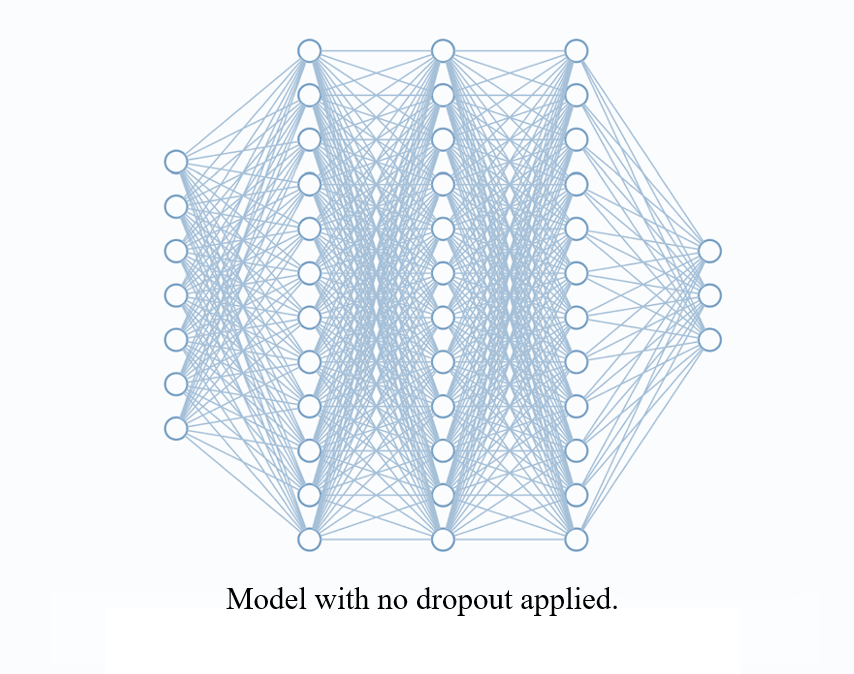

In [76]:

from IPython.display import Image
Image(filename='Model_with_no_dropout.png') 


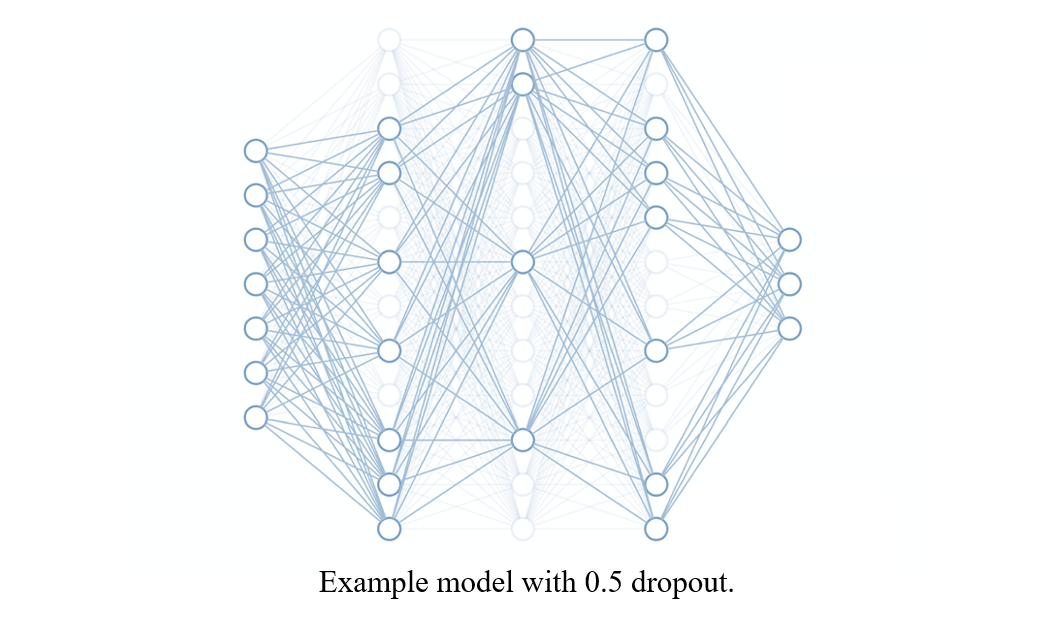

In [77]:

from IPython.display import Image
Image(filename='Model_with_0.5_dropout.png',width=850) 


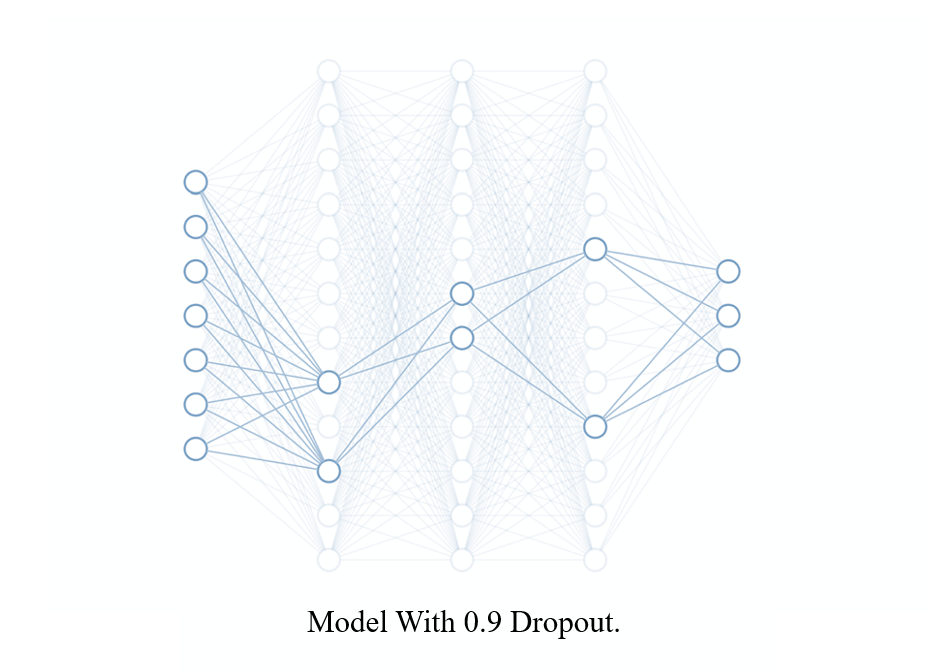

In [78]:

from IPython.display import Image
Image(filename='Model_with_0.9_dropout.png',width=850) 


With the code, we have one hyperparameter for a dropout layer. This is a value for the percentage of neurons to disable in that layer. For example, if you chose 0.10 for the dropout parameter, 10% of the neurons will be disabled at random during each forward pass. 

Before we use NumPy, we will demonstrate this with an example in pure Python:

In [79]:

import random 

random.seed(42)

dropout_rate = 0.5 

# Example output containing 10 values 
example_output = [0.27, -1.03, 0.67, 0.99, 0.05, -0.37, -2.01, 1.13, -0.07, 0.73] 

# Repeat as long as necessary 
while True: 
 
    # Randomly choose index and set value to 0 
    index = random.randint(0, len(example_output) - 1) 
    example_output[index] = 0 
 
    # We might set an index that already is zeroed 
    # There are different ways of overcoming this problem, 
    # for simplicity we count values that are exactly 0 
    # while it's extremely rare in real model that weights 
    # are exactly 0, this is not the best method for sure 
    dropped_out = 0 
    for value in example_output: 
        if value == 0: 
            dropped_out += 1 
 
    # If required number of outputs is zeroed - leave the loop 
    if dropped_out / len(example_output) >= dropout_rate: 
        break 
 
print(example_output) 


[0, 0, 0, 0, 0, -0.37, -2.01, 1.13, -0.07, 0.73]


The code is relatively rudimentary, but the idea is to keep zeroing neuron outputs (setting them to 0) randomly until we have disabled whatever target **%** of neurons we require. If we consider a **Bernoulli distribution** as a special case of a Binomial distribution with n=1​ and look at a list of available methods in NumPy, it turns out that there’s a much cleaner way to do this using **numpy.random.binomial**​. A binomial distribution differs from Bernoulli distribution in one way, as it adds a parameter, n,​ which is the number of concurrent experiments (instead of just one) and returns the number of successes from these n​ experiments. 

np.random.binomial() works by taking the already discussed parameters n(number of experiments) and p (probability of the true value of the experiment) aswell as an additional parameter size​: np.random.binomial(n, p, size). 

The function itself can be thought of like a coin toss, where the result will be 0 or 1. The n​ is how many tosses of the coin do you want to do. The p​ is the probability for the toss result to be a 1. The overall result is a sum of all toss results. The size​ is how many of these “tests” to run, and the return is a list of overall results. For example: 

In [80]:

import numpy as np
results = np.random.binomial(2, 0.5, size=10) 



This will produce an array that is of size 10, where each element will be the sum of 2 coin tosses, where the probability of 1 will be 0.5, or 50%. The resulting array: 


In [81]:

results


array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1])


We can use this to create our dropout layer. Our goal here is to create a filter where the intended dropout % is represented as 0, with everything else as 1. For example, let’s say we have a dropout layer that we will add after a layer that consists of 5 neurons, and we wish to have a 20% dropout. An example of a dropout layer might look like: 

This is an example of the filter we are going to apply to the output of the dense layer. If we multiplied a neural network’s layer output by this, we would be effectively disabling the neuron at the same index as the 0.

We can mimic that with **np.random.binomial()** by doing:

In [82]:

dropout_rate = 0.20 
results = np.random.binomial(1, 1-dropout_rate, size=5)


In [83]:

results


array([1, 1, 1, 0, 1])

This is based on **probabilities**, so there will be times when it does not look like the above array. There could be times no neurons zero out, or all neurons zero out. On average, these random draws will tend toward the probability we desire. Also, this was an example using a very small layer (5 neurons). On a realistically sized layer, you should find the probability more consistently 
matches your intended value. 

Assume a neural network layer’s output is: 

In [84]:

example_output = np.array([0.27, -1.03, 0.67, 0.99, 0.05, -0.37, -2.01, 1.13, -0.07, 0.73]) 


Now, assume our target dropout rate is 0.3, or 30%. We apply a dropout layer: 

In [85]:

dropout_rate = 0.3 

example_output *= np.random.binomial(1, 1-dropout_rate, example_output.shape) 
 

In [86]:

print(example_output)


[ 0.27 -1.03  0.67  0.99  0.   -0.37 -2.01  0.   -0.    0.  ]


***
## ***Backward Pass***
***

The last missing piece to implement dropout as a layer is a backward pass method. As before, we need to calculate the partial derivative of the dropout operation: When the value of element r​ i​ equals 1​, its function and derivative becomes the neuron’s output, z​, compensated for the loss value by 1-q​, where q​ is the dropout rate, as we just described:

$$f(z, q) = \frac{z}{1-q} \rightarrow \frac{∂}{∂z}[\frac{z}{1-q}] = \frac{1}{1-q} \cdot \frac{∂}{∂z}z = \frac{1}{1-q} \cdot 1 = \frac{1}{1-q}$$

That's because the derivative with respect to z of z is 1, and we treat the rest as a constant.

When r=0:

$$f(z, q) = 0 \rightarrow \frac{∂}{∂z} 0 = 0$$

And that's because we are zeroing this element of the dropout filter, and the derivative of any
constant value (including 0) is 0. Let's combine both cases and denote Dropout as Dr:

$$Dr_i = \begin{cases}
    \frac{z_i}{1-q} & r_i = 1 \\
    0 & r_i = 0
\end{cases} \rightarrow \frac{∂}{∂z_i} Dr_i = \begin{cases}
    \frac{1}{1-q} & r_i = 1 \\
    0 & r_i = 0
\end{cases} = \frac{r_i}{1-q}$$

i denotes the index of the given input (and the layer output). When we write a derivative of the dropout function this way, we can simplify it to a value from the Bernoulli distribution divided by 1-q, which is identical to our scaled mask, the function the dropout applies during the forward pass, as it's also either 1 divided by 1-q, or 0. Thus, we can save this mask during the forward
pass and use it with the chain rule as the gradient of this function.